In [102]:
import numpy as np
from scipy.linalg import expm, sinm, cosm
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

In [173]:
def theoretical_acf(rho, upper_bound):
    acf = []
    acf_denom = 0.0
    
    for j in range(0,20):
        acf_denom = acf_denom+ ( (rho)**(2j) / (math.factorial(j)*math.factorial(j) ) )


    for h in range(0,upper_bound):
        acf_num = 0.0
        
        for j in range(0,20):
            acf_num = acf_num + ( (rho)**(2j+h) / (math.factorial(j)*math.factorial(j+h) ) )
        
        acf.append( (acf_num/acf_denom).real)
        
    return acf

In [203]:
max_h = 10
acf_df = pd.DataFrame(columns = range(0,max_h))

acf_df.loc[0] = np.zeros(max_h)
acf_df.loc[0,0]=1

rho_grid = np.append(np.linspace(.1,1,10),np.array([1.5,2.0]))
for rho in rho_grid:
    acf_df.loc[rho] = np.array(theoretical_acf(rho, max_h))
    
acf_df = acf_df.reset_index()

Text(0.5, 1.0, 'ACF for various values of rho')

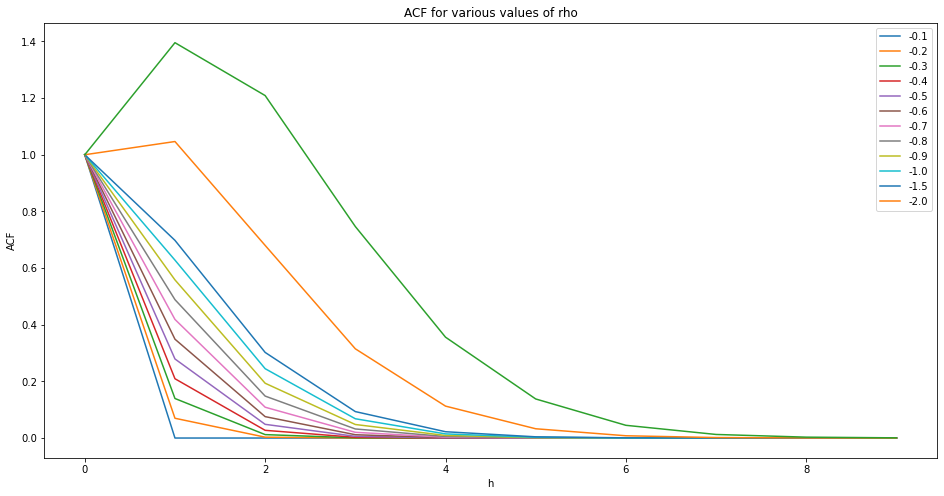

In [206]:
fig, ax = plt.subplots(figsize = (16,8))

pd.pivot_table(acf_df, columns = 'index').plot(ax = ax)
ax.legend( np.round(-1*rho_grid,1)  )

ax.set_xlabel('h')
ax.set_ylabel('ACF')
ax.set_title('ACF for various values of rho')

In [172]:
sample_size = 50
L_approx = np.zeros([sample_size, sample_size])

for row in range(0,len(L_approx)-1):
    L_approx[row][row+1] =1
    
L_approx[sample_size -1 ] = np.ones(sample_size)/sample_size

phi = -1
wold_operator = np.linalg.inv(expm(phi*L_approx))

Text(0.5, 0, 'Time')

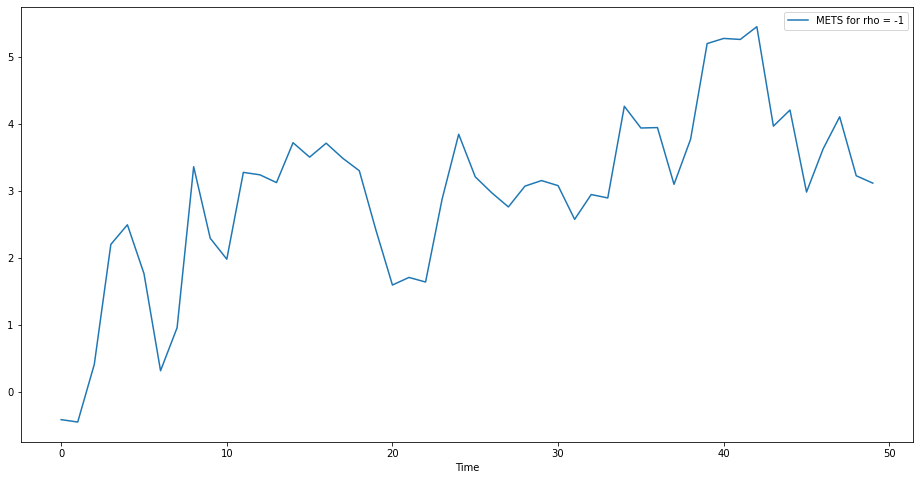

In [99]:
ep = np.random.normal(1,1,sample_size)
ts = np.dot(wold_operator,ep)

fig, ax = plt.subplots(figsize = (16,8))
pd.DataFrame(ts).plot(ax = ax)
ax.legend(['METS for rho = -1'])
ax.set_xlabel('Time')

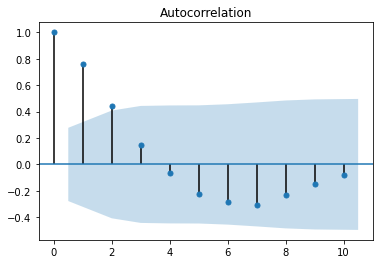

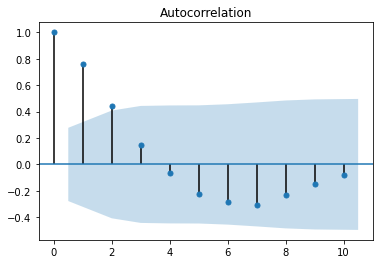

In [96]:
sm.graphics.tsa.plot_acf(ts, lags=10)

In [277]:
def msts_filter(alpha, rho, ts,y0):
    state_space = [y0]
    fitted = [y0]
    
    sample_length = len(ts)
    for time in range(1,sample_length):
        state_space  = np.append(ts[time],state_space)
        state_space = rho*state_space
        
        for entry in range(0, len(state_space)):
            state_space[entry] = state_space[entry]/math.factorial(entry+1)
            
        fitted = np.append(fitted, alpha + np.sum(state_space) )
        
    return fitted

def ols_msts(ts,grid_size):
    ts_mean = np.mean(ts)
#     y0 = np.mean(ts)
    y0 = ts[0]
    
    min_alpha = 0.0
    min_rho = 0.0
    min_obj = np.square(ts - msts_filter(0.0, 0.0,ts,y0)).mean()
    
    for alpha in np.linspace(-ts_mean, ts_mean, grid_size):
        for rho in np.linspace(-2,2,grid_size):
            obj = np.square(ts - msts_filter(alpha, rho,ts,y0)).mean()
            
            if obj < min_obj:
                min_alpha = alpha
                min_rho = rho
                min_obj = obj
                
    return [min_alpha, min_rho]

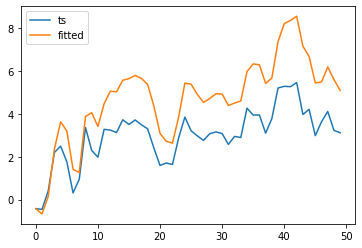

In [278]:
pd.DataFrame({'ts':ts, 'fitted':msts_filter(0,1,ts, ts[0])}).plot()

In [279]:
ols_coefs = ols_msts(ts,20)
ols_coefs

[-0.15605755287990197, 0.7368421052631575]

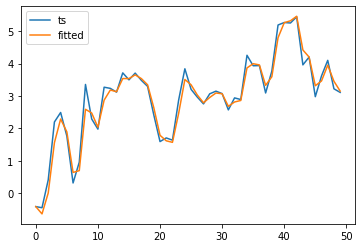

In [280]:
pd.DataFrame({'ts':ts, 'fitted':msts_filter(ols_coefs[0],ols_coefs[1],ts, ts[0] )}).plot()

In [281]:
income_ts = pd.read_excel('C:/Users/michelj8/Downloads/fred_household_income.xls', sheet_name = 'data')
income_ts.head()

,observation_date,MEHOINUSA672N
0,1984-01-01,52679
1,1985-01-01,53664
2,1986-01-01,55597
3,1987-01-01,56261
4,1988-01-01,56725


In [284]:
income_ts['Y'] = np.log(income_ts['MEHOINUSA672N'])

In [294]:
income_ols_coefs = ols_msts( income_ts['MEHOINUSA672N'] ,25)

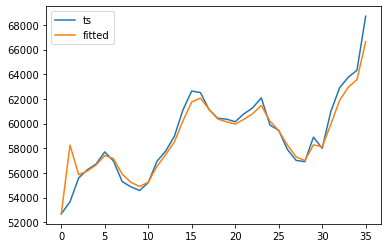

In [295]:
pd.DataFrame({'ts':income_ts['MEHOINUSA672N'], 'fitted':msts_filter(income_ols_coefs[0],income_ols_coefs[1],income_ts['MEHOINUSA672N'], income_ts['MEHOINUSA672N'][0])}).plot()
# pd.DataFrame({'ts':income_ts['Y'], 'fitted':msts_filter(income_ols_coefs[0],income_ols_coefs[1],income_ts['Y'], income_ts['Y'][0])}).plot()

In [296]:
income_ols_coefs

[4917.8263888888905, 0.6666666666666665]

In [302]:
from statsmodels.tsa.arima.model import ARIMA

arma_model = ARIMA(income_ts['MEHOINUSA672N'], order=(1, 0, 0)).fit()
print(arma_model.params)

const     5.901392e+04
ar.L1     9.734766e-01
sigma2    2.050352e+06
dtype: float64


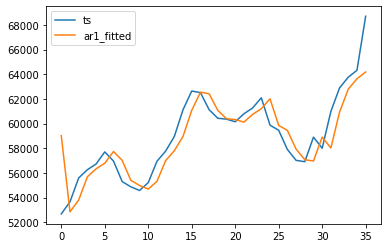

In [308]:
pd.DataFrame({'ts':income_ts['MEHOINUSA672N'], 'ar1_fitted':arma_model.predict() }).plot()